In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
#------------ Charger et prétraiter les images --------------- :
# Répertoires 
train_dir=r"C:\Users\Latitude\Desktop\Détection d’Émotions Faciales\DATA\train"
print(os.path.exists(train_dir)) 
test_dir=r"C:\Users\Latitude\Desktop\Détection d’Émotions Faciales\DATA\test"
print(os.path.exists(test_dir))           # sert à vérifier si le dossier que tu veux utiliser existe vraiment sur ton ordinateur.





True
True


In [2]:
# lES PARAMETRES : 
# DATA/Train
batch_size=32
img_height=224
img_width=224
train_DT=tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=(img_height,img_width),
    batch_size=batch_size,
    label_mode='int'
)


print(train_DT.class_names)             # il affiche les classe que on a 


Found 28709 files belonging to 7 classes.
['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [3]:
# LES PARAMETRES :
batch_size=32
img_height=224
img_width=224
# DATA/Test
test_DT=tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)
print(test_DT.class_names)

Found 7178 files belonging to 7 classes.
['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


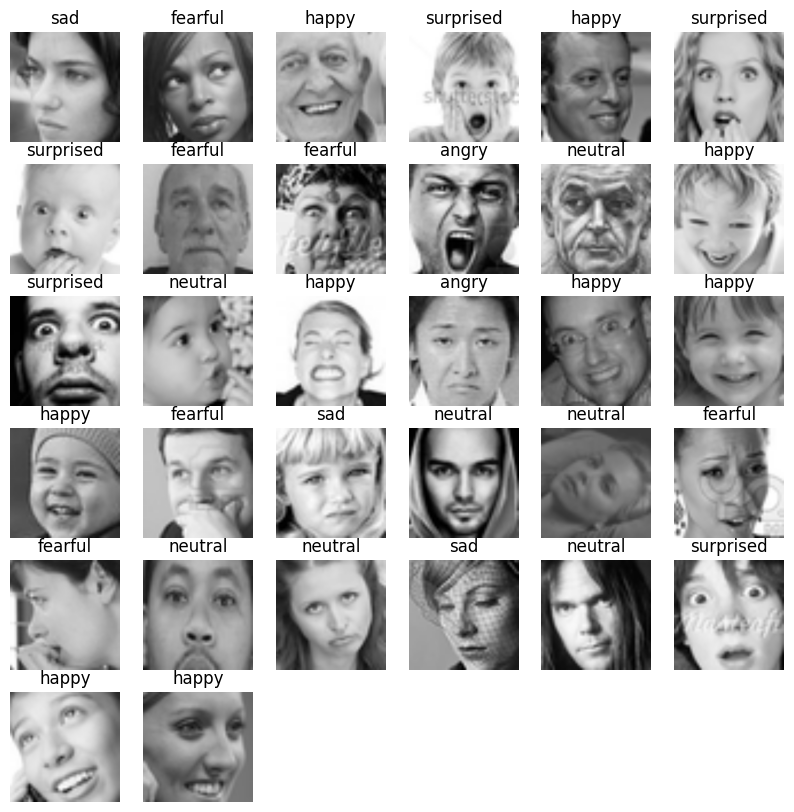

In [4]:
import matplotlib.pyplot as plt
classes_images=train_DT.class_names
print(classes_images)
plt.figure(figsize=(10,10))
for images, labels in train_DT.take(1):
    for i in range(batch_size):
        ax = plt.subplot(6,6,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classes_images[labels[i]])
        plt.axis("off")
plt.show()

In [5]:
# normalisation : 
normalisation_layer=tf.keras.layers.Rescaling(1./255)
train_DT=train_DT.map(lambda x,y : (normalisation_layer(x),(y)))
test_DT=test_DT.map(lambda x, y : (normalisation_layer (x),(y)))
print(train_DT)
print(test_DT)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 
une explication de tous ca 

- shapes → la forme des tensors pour chaque batch :

(None, 224, 224, 3) → None = taille du batch (ex. 32), 224x224 = dimension de l’image, 3 = canaux RGB

(None,) → labels pour chaque image du batch

- types → le type de données :

tf.float32 → les images (après normalisation)

tf.int32 → les labels

In [6]:
# Data Augmentation :
from keras import Sequential

data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),        # flip horizontal
    tf.keras.layers.RandomRotation(0.1),  # rotation légère
    tf.keras.layers.RandomZoom(0.1),   # zoom légèr
])
# est la fraction de 2π radians (ou de 360°) maximale pour la rotation. 0.1 = ±10 % d’une rotation complète / rotation complète = 360°, 0.1 correspond à ±36°
train_DT = train_DT.map(lambda x, y: (data_augmentation(x, training=True), y))


In [8]:
# entrainement de CNN  et créer un modele :
from tensorflow.keras import layers, models      # Keras est une interface simple pour construire des réseaux de neurones.

model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Conv2D(128,(3,3), activation='relu'),
    # layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    # layers.Dense(64, activation='relu'),
    # layers.Dropout(0.2),    
    # Couche de sortie
    layers.Dense(len(classes_images), activation='softmax'),
])
# for layer in model.layers :
#     print(layer)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │     1,306,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,767 (5.06 MB)

 Trainable params: 1,325,767 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping= EarlyStopping( monitor='val_loss', patience=5, mode='min',restore_best_weights= True)

In [ ]:
from sklearn.model_selection import *
from tensorflow.keras import *
import numpy as np

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = model.fit(train_DT, validation_data=test_DT, epochs=3)



Epoch 1/3
372/898 ━━━━━━━━━━━━━━━━━━━━ 13:49 2s/step - accuracy: 0.3340 - loss: 1.6946